# Hypothesis testing with discrete distributions

A tool for testing if a hypothesis of a discrete distribution of the random variable $P$ is consistent with an observed distribution of a discrete random variable $Q$ is the Kullback-Leibler discrepancy 

$$D_{\mathrm{KL}}(P|Q) = \sum_i P_i\log\left(\frac{P_i}{Q_i}\right)\quad,$$ 

where the sum runs over all possible (discrete) outcomes of $P$. 

Given the observation of the prevalence of each of the digits $0,1,\ldots,9$ in the number $\pi-3$ up to some number of digits $N$

In [1]:
prev = {1000:    [   93,  116,   103,   102,    93,    97,   94,   95,  101,   106],
        10000:   [  968, 1026,  1021,   974,  1012,  1046, 1021,  970,  948,  1014],
        100000:  [ 9999,10137,  9908, 10025,  9971, 10026,10029,10025, 9978,  9902],
        1000000: [99959,99758,100026,100229,100230,100359,99548,99800,99985,100106]}
print(f'{"N":7s} '+' '.join([f'{d:6d}' for d in range(10)]) + '\n' +
      '\n'.join([f'{n:7d} ' + ' '.join([f'{m:6d}' for m in mm]) for n,mm in prev.items()]))

N            0      1      2      3      4      5      6      7      8      9
   1000     93    116    103    102     93     97     94     95    101    106
  10000    968   1026   1021    974   1012   1046   1021    970    948   1014
 100000   9999  10137   9908  10025   9971  10026  10029  10025   9978   9902
1000000  99959  99758 100026 100229 100230 100359  99548  99800  99985 100106


we can calculate $D_{\mathrm{KL}}$ assuming that all digits are equally likely - i.e., $p_i=1/10$. 

We define a function to calculate $D_{\mathrm{KL}}$ given $p_i$, and $q_i=m_i/n$, where $q_i$ is the number of times we have outcome $i$ out of $n$ trials. 

In [2]:
def dkl(p,m,n):
    from numpy import log, atleast_1d
    p1 = atleast_1d(p)
    m1 = atleast_1d(m)
    
    return (p1 * np.log(p1/(m1/n))).sum()

Let us evaluate $D_{\mathrm{KL}}$ for each $N$ and plot that versus $N$. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, '$D_{\\mathrm{KL}}$ of prevalence of digits in $\\pi-3$')

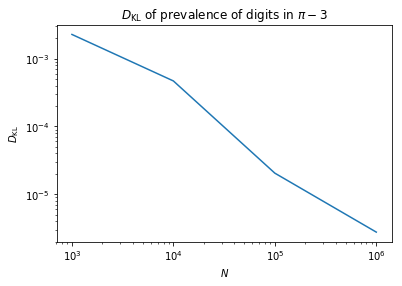

In [4]:
dkl1 = np.array([(n,dkl(1/10,m,n)) for n,m in prev.items()])
plt.plot(dkl1[:,0],dkl1[:,1])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$N$')
plt.ylabel(r'$D_{\mathrm{KL}}$')
plt.title(r'$D_{\mathrm{KL}}$ of prevalence of digits in $\pi-3$')

To appreciate what this means, consider $N=1000$ random digits $Q \sim U\{0,9\}$ - what is the expected $D_{\mathrm{KL}}$ of that?   To evaluate the expectation value, we perform $M=1000$ such experiments and calculate the mean. 

First, a function to do $M$ experiments each drawing $N$ random digits, and returning $D_{\mathrm{KL}}$ for each experiment. 

In [5]:
def randdkl(ntries,n):
    from numpy import unique, array
    from numpy.random import randint
    
    return array([dkl(1/10,unique(r,return_counts=True)[1],n)
                  for r in randint(0,10,size=(ntries,n))])

We would like to draw the result of the experiments as a distribution and overlay the $\pi-3$ discrepancy, and evaluate how many of our experiments had a $D_{\mathrm{KL}}$ value that is higher.  The function below does that. 

In [6]:
def draw_randdkl(t,n,pi3):
    from matplotlib.pyplot import gca
    from numpy import log10,sqrt
    
    ax = gca()
    
    ax.hist(t,100,label=r'Random sampling of $U~\{0,9\}$')
    
    m   = int(log10(len(t)+.5))
    mu  = t.mean()
    dmu = t.std()/sqrt(len(t))
    ax.axvline(mu,color='C1',ls='--',
               label=r'$\overline{D_{\mathrm{KL}}}='
                      +fr'{mu:.{m+1:}f}\pm'
                      +fr'{dmu:.{m+1}f}$')
    
    if pi3.get(n,False):
        pdkl = dkl(1/10,pi3[n],n)
        ax.axvline(pdkl,color='C2',ls='-.',
                   label=fr'$\pi-3\ D_{{\mathrm{{KL}}}}={pdkl:.{m+1:}f}$')
        
        l = (t>pdkl).sum()/len(t)
        ax.text(.5,.5,fr'${l*100:.1f}\%$ larger than for $\pi-3$',
                transform=gca().transAxes)
                    
    ax.set_xlabel(r'$D_{{\mathrm{{KL}}}}$')
    ax.set_title(fr'$D_{{\mathrm{{KL}}}}$ for $N={n}$')
    ax.legend();

We run the test for $N=1000$ and $M=10000$.  

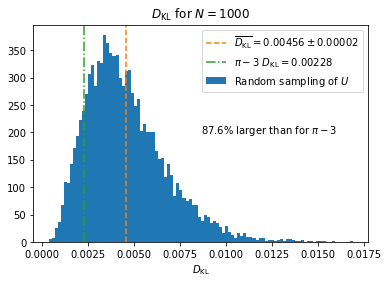

In [7]:
t = randdkl(10000,1000)
draw_randdkl(t,1000,prev)

We see that the $\pi-3$ discrepancy is actually quite low from what we would expect.  

Let us use the function above to calculate the mean discrepancy for each of the $N$ given for $\pi-3$ above, and plot these together. 

In [8]:
def randdkl_m(m,n):
    from numpy import sqrt, percentile
    d = randdkl(m,n)
    return [percentile(d,p) for p in (50,5,95,50-65/2.,50+65/2)]

data = np.array([(n,dpi,*randdkl_m(1000,int(n))) for n,dpi in dkl1])

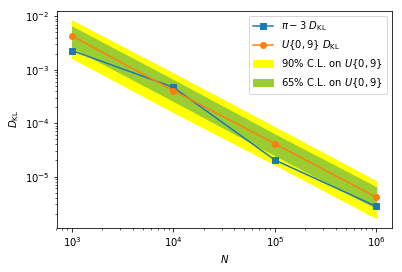

In [9]:
plt.plot(data[:,0],data[:,1],'-s',label=r'$\pi-3\ D_{\mathrm{KL}}$')
plt.fill_between(data[:,0],data[:,3],data[:,4],color='yellow',
                 label=r'$90\%$ C.L. on $U\{0,9\}$')
plt.fill_between(data[:,0],data[:,5],data[:,6],color='yellowgreen',
                 label=r'$65\%$ C.L. on $U\{0,9\}$')
plt.plot(data[:,0],data[:,2],'-o',label=r'$U\{0,9\}\ D_{\mathrm{KL}}$')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$N$')
plt.ylabel(r'$D_{\mathrm{KL}}$')
plt.legend();

Here, the picture changes a bit.  In fact, the $\pi-3$ numbers are consistent with the random draw experiment within $90\%$ confidence limits, and mostly within $65\%$.  Thus, the assumption that the digits of $\pi$ are uniformly distributed cannot be rejected at any reasonable limit. 